In [43]:
# MFCC
# Import modules
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

def get_mfccs(data_set):
    mfcc_dict = {}
    for datafile, label in dataset.iteritems():
        # Import data
        fs, data = scipy.io.wavfile.read(datafile)
        # Set window size
        win_size = 0.025 # ms
        win_shift = 0.010 # ms
        # Convert from seconds to samples
        win_len, win_step = win_size*fs, win_shift*fs
        nsamples = len(data)
        win_len = int(round(win_len))
        win_step = int(round(win_step))
        # Round up for number of windows so can't be 0
        nwins = int(np.ceil(float(np.abs(nsamples - win_len))/win_step))
        # Pad signal so can divide exactly into windows
        npad = nwins * win_step + win_len
        data = np.append(data, np.zeros((npad - nsamples))) # Pad signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
        # Extract windows
        indices = np.tile(np.arange(0, win_len), (nwins, 1)) + np.tile(np.arange(0, nwins*win_step, win_step), (win_len, 1)).T
        wins = data[indices.astype(np.int32, copy = False)]
        # Apply hamming window
        wins *= np.hamming(win_len)
        # Calculate fft
        NFFT = 512
        # Extract magnitude of the FFT over windows
        mag_wins = np.absolute(np.fft.rfft(wins, NFFT))
        # Convert to power Spectrum
        pow_wins = ((1.0/NFFT)*((mag_wins)**2))
        # Apply Mel-frequency triangular filters
        # Number of filters
        nfilts = 40
        # Mel-frequency range
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (fs/2)/700))
        # Create equally spaced points in Mel scale
        mel_pts = np.linspace(low_freq_mel, high_freq_mel, nfilts + 2)
        # Calculate Hz correspondence
        hz_pts = (700*(10**(mel_pts/2595) - 1))
        bin = np.floor((NFFT + 1)*hz_pts/fs)
        # Calculate Mel-filter banks
        fbank = np.zeros((nfilts, int(np.floor(NFFT/2 + 1))))
        for m in range(1, nfilts + 1):
            # Calculate edge and center frequencies
            f_m_minus = int(bin[m - 1])
            f_m = int(bin[m])
            f_m_plus = int(bin[m + 1])
            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1])/(bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k)/(bin[m + 1] - bin[m])
        fbanks = np.dot(pow_wins, fbank.T)
        fbanks = np.where(fbanks == 0, np.finfo(float).eps, fbanks)  # Numerical Stability
        # Convert to dB
        fbanks = 20 * np.log10(fbanks)
        # Extract Mel-frequency cepstral coefficients (MFCCs)
        nceps = 12
        mfccs = dct(fbanks, type = 2, axis = 1, norm = 'ortho')[:, 1:(nceps + 1)] # Keep 2nd onwards
        mfcc_dict[label] = mfccs
    return mfcc_dict

dataset = {'digits/1a.wav':'1', 'digits/2a.wav':'2','digits/3a.wav':'3','digits/4a.wav':'4','digits/5a.wav':'5','digits/6a.wav':'6','digits/7a.wav':'7','digits/8a.wav':'8','digits/9a.wav':'9','digits/oa.wav':'o','digits/za.wav':'z'}
testset = {'digits/1b.wav':'1', 'digits/2b.wav':'2','digits/3b.wav':'3','digits/4b.wav':'4','digits/5b.wav':'5','digits/6b.wav':'6','digits/7b.wav':'7','digits/8b.wav':'8','digits/9b.wav':'9','digits/ob.wav':'o','digits/zb.wav':'z'}

#Generate dictionaires for mfccs of both "a" and "b" tracks
mfcc_dict = get_mfccs(dataset)
mfcc_test = get_mfccs(testset)

In [44]:
# DTW
# Import modules
import math

import numpy as np
import operator
# Create function to calculate Euclidean distance between feature vectors
def eudistVec(x, y):
    # Convert scalar inputs to vectors
    if not type(x) is list:
        x = [x]
    if not type(y) is list:
        y = [y]
        # Return Euclidean distance
    return math.sqrt(sum(list(map(lambda x, y: (x - y)**2, x, y))))
# Create function to do dynamic time warp
def dynamTimeWarp(x, y):
    # Convert scalar inputs to vectors
    if not type(x) is list:
        x = x.tolist()
    if not type(y) is list:
        y = y.tolist()
    # Initialize path matrix
    DTW = np.zeros([len(x), len(y)])
    # Calculate paths
    for i in range(len(x)):
        for j in range(len(y)):
            dist = eudistVec(x[i], y[j])
            if not i and not j:
                choices = float('inf'), float('inf'), 0
            elif not i and j:
                choices = float('inf'), DTW[i, j-1], float('inf')
            elif i and not j:
                choices = DTW[i-1, j], float('inf'), float('inf')
            else:
                choices = DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1]
            DTW[i, j] = dist + min(choices)
    # Return score/error of best path (lower is better)
    return DTW[-1, -1]
# Test algorithm
A = [[0, 0], [1, 0], [2, 0], [3, 0], [0, 0]]
B = [[0, 0], [0, 0], [1, 1.5], [2, 1], [3, 0.5], [0, 0], [0, 0], [0, 0]]
score = dynamTimeWarp(A, B)
score

3.0

In [45]:
# Test algorithm on MFCCs
for datafile1, mfccs1 in mfcc_dict.iteritems():
    for datafile2, mfccs2 in mfcc_test.iteritems():
        print datafile1 + " to " + datafile2
        print dynamTimeWarp(mfccs1, mfccs2)
        print

o to o
0.0

o to 1
4766.572574730714

o to 3
5268.796716068932

o to 2
6047.499467261337

o to 5
6670.971909342609

o to 4
5957.716002001052

o to 7
6640.146121573079

o to 6
9465.244181955819

o to 9
5817.893304293583

o to 8
6457.269027330199

o to z
5505.052401316003

1 to o
4766.572574730714

1 to 1
0.0

1 to 3
4707.080550513835

1 to 2
5661.022337974292

1 to 5
6399.667594783417

1 to 4
6028.463732615059

1 to 7
5949.084692720346

1 to 6
8819.773422210494

1 to 9
4393.544673426008

1 to 8
6206.135846975853

1 to z
5515.214457302429

3 to o
5268.796716068932

3 to 1
4707.080550513835

3 to 3
0.0

3 to 2
4400.6990829631895

3 to 5
6533.569461420866

3 to 4
6790.266285068713

3 to 7
5850.944010454769

3 to 6
7912.6604205167505

3 to 9
5003.8852410694635

3 to 8
5538.851547928536

3 to z
5081.472568907088

2 to o
6047.499467261337

2 to 1
5661.022337974292

2 to 3
4400.6990829631895

2 to 2
0.0

2 to 5
7301.090695631092

2 to 4
7262.192274501199

2 to 7
5508.349941173367

2 to 6
6912.

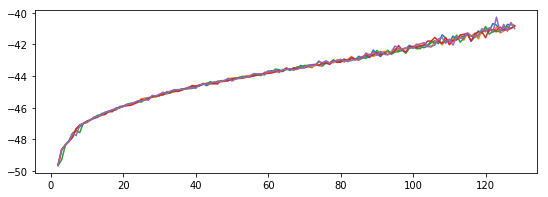

In [50]:
# Extension 3
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib as mpl


n_components = 32
cv_type = "diag"
plt.figure(1, figsize=(9, 3))
for i in range(5):
    x_cords = []
    score_cords = []
    for n_components in range(2, 129):
        gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
        gmm.fit(np.vstack(mfcc_dict.values()))
        x_cords.append(n_components)
        score = gmm.score(np.vstack(mfcc_test.values()))
        score_cords.append(score)
    plt.plot(x_cords,score_cords)

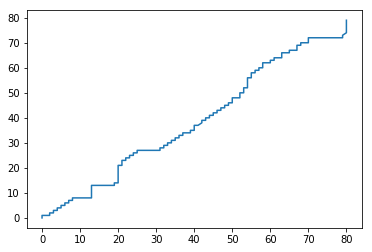

In [58]:
# Extension 2
def dynamTimeWarpPlot(x, y):
    x_cords = []
    y_cords = []
    # Convert scalar inputs to vectors
    if not type(x) is list:
        x = x.tolist()
    if not type(y) is list:
        y = y.tolist()
    # Initialize path matrix
    DTW = np.zeros([len(x), len(y)])
    # Calculate paths
    for i in range(len(x)):
        for j in range(len(y)):
            dist = eudistVec(x[i], y[j])
            if not i and not j:
                choices = float('inf'), float('inf'), 0
            elif not i and j:
                choices = float('inf'), DTW[i, j-1], float('inf')
            elif i and not j:
                choices = DTW[i-1, j], float('inf'), float('inf')
            else:
                choices = DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1]
            DTW[i, j] = dist + min(choices)
    i = 0
    j = 0
    x_cords = [0]
    y_cords = [0]
    while i != len(x)-1 or j != len(y)-1:
        if i == len(x)-1:
            j = j+1
        elif  j == len(y)-1:
            i = i+1
        else:
            choices = DTW[i+1, j+1], DTW[i+1, j], DTW[i, j+1]
            choice = np.argmin(choices)
            if choice == 0:
                i = i+1
                j = j+1
            elif choice == 1:
                i = i+1
            else:
                j = j+1
        x_cords.append(i)
        y_cords.append(j)
    plt.plot(x_cords, y_cords)
            
dynamTimeWarpPlot(mfcc_dict['5'], mfcc_dict['9'])